<a href="https://colab.research.google.com/github/xesmaze/cpsc499-sta-fall2024/blob/main/ModelingSpatialVariability-Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

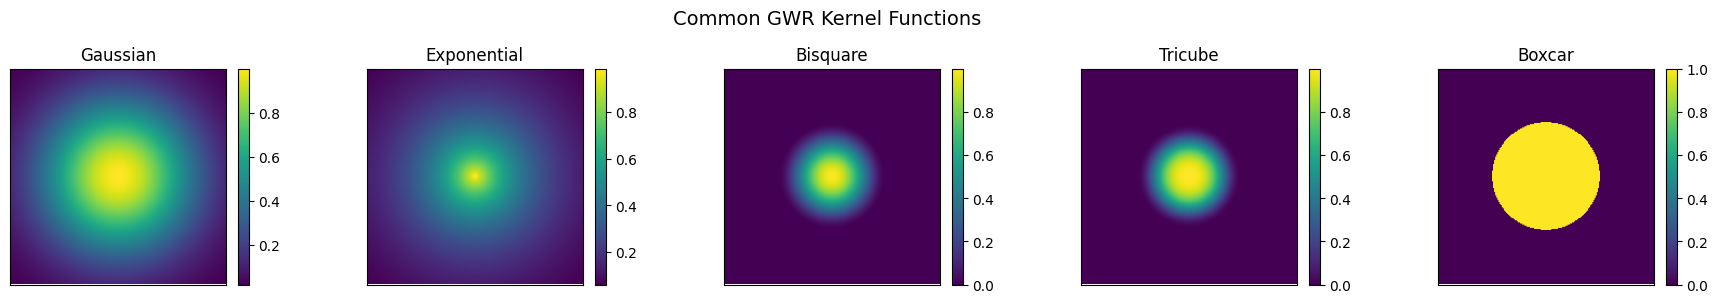

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid
n = 200
x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
X, Y = np.meshgrid(x, y)
D = np.sqrt(X**2 + Y**2)  # radial distance from center
b = 0.5                   # bandwidth

# Define kernel functions
def gaussian_kernel(d, b): return np.exp(-0.5 * (d / b)**2)
def exponential_kernel(d, b): return np.exp(-d / b)
def bisquare_kernel(d, b): return np.where(d < b, (1 - (d / b)**2)**2, 0)
def tricube_kernel(d, b): return np.where(d < b, (1 - (np.abs(d) / b)**3)**3, 0)
def boxcar_kernel(d, b): return np.where(d < b, 1, 0)

kernels = {
    "Gaussian": gaussian_kernel(D, b),
    "Exponential": exponential_kernel(D, b),
    "Bisquare": bisquare_kernel(D, b),
    "Tricube": tricube_kernel(D, b),
    "Boxcar": boxcar_kernel(D, b)
}

# Plot as heatmaps
fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for ax, (name, W) in zip(axes, kernels.items()):
    im = ax.imshow(W, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
    ax.set_title(name)
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("Common GWR Kernel Functions", fontsize=14)
plt.tight_layout()
plt.show()


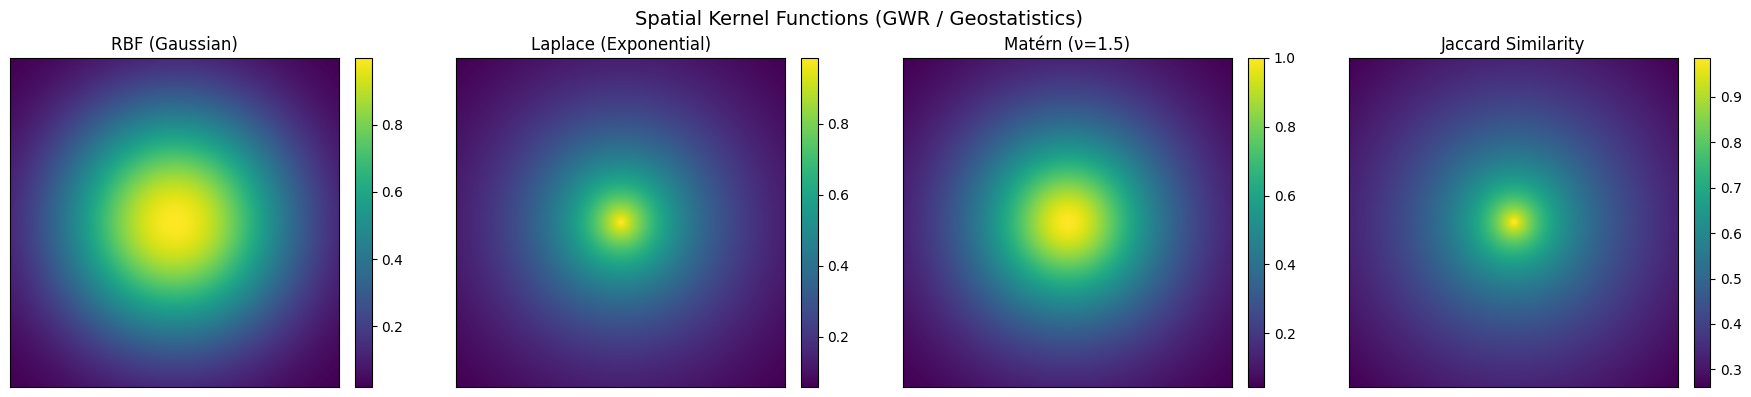

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, gamma

# ---- Define grid ----
n = 200
x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
X, Y = np.meshgrid(x, y)
D = np.sqrt(X**2 + Y**2)  # Euclidean distance
b = 0.5                   # bandwidth / scale parameter

# ---- Kernel definitions ----

# 1️⃣ Radial Basis Function (Gaussian / squared-exponential)
def rbf_kernel(d, b):
    return np.exp(-0.5 * (d / b)**2)

# 2️⃣ Laplace (Exponential) kernel
def laplace_kernel(d, b):
    return np.exp(-np.abs(d) / b)

# 3️⃣ Matérn kernel (ν=1.5 or 2.5 are common)
def matern_kernel(d, b, nu=1.5):
    """
    Matérn kernel:
    K(d) = (1/(Γ(ν)2^(ν−1))) * (sqrt(2ν)*d/b)^ν * K_ν(sqrt(2ν)*d/b)
    where K_ν is the modified Bessel function of the second kind
    """
    d_scaled = np.sqrt(2*nu) * d / b
    d_scaled = np.where(d_scaled == 0, 1e-10, d_scaled)  # avoid division by zero
    term = (2**(1 - nu)) / gamma(nu)
    K = term * (d_scaled**nu) * kv(nu, d_scaled)
    return K / np.max(K)  # normalize to [0,1]

# 4️⃣ Jaccard similarity (distance-based similarity)
def jaccard_kernel(d, b):
    """
    Continuous analog of Jaccard similarity: 1 - (d / (d + b))
    Ensures bounded similarity decaying with distance.
    """
    return 1 - (d / (d + b))

# ---- Compute all kernels ----
kernels = {
    "RBF (Gaussian)": rbf_kernel(D, b),
    "Laplace (Exponential)": laplace_kernel(D, b),
    "Matérn (ν=1.5)": matern_kernel(D, b, nu=1.5),
    "Jaccard Similarity": jaccard_kernel(D, b)
}

# ---- Plot as heatmaps ----
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for ax, (name, W) in zip(axes, kernels.items()):
    im = ax.imshow(W, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
    ax.set_title(name)
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("Spatial Kernel Functions (GWR / Geostatistics)", fontsize=14)
plt.tight_layout()
plt.show()


If you have sampled kernel weights from irregular spatial data, you can interpolate them to a regular grid using the following

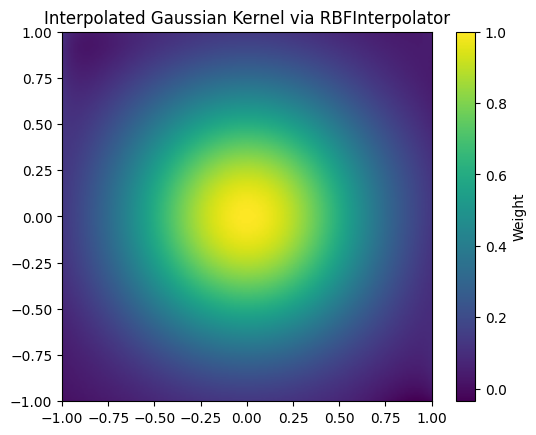

In [3]:
from scipy.interpolate import RBFInterpolator

points = np.random.rand(100, 2) * 2 - 1
values = np.exp(-np.linalg.norm(points, axis=1)**2 / (2*b**2))

interp = RBFInterpolator(points, values, kernel='gaussian', epsilon=b)
W_interp = interp(np.column_stack([X.ravel(), Y.ravel()])).reshape(X.shape)

plt.imshow(W_interp, extent=[-1,1,-1,1], origin='lower', cmap='viridis')
plt.title("Interpolated Gaussian Kernel via RBFInterpolator")
plt.colorbar(label="Weight")
plt.show()


If there is anisotropy(eliptical instead of spherical patterns) you can use the following:

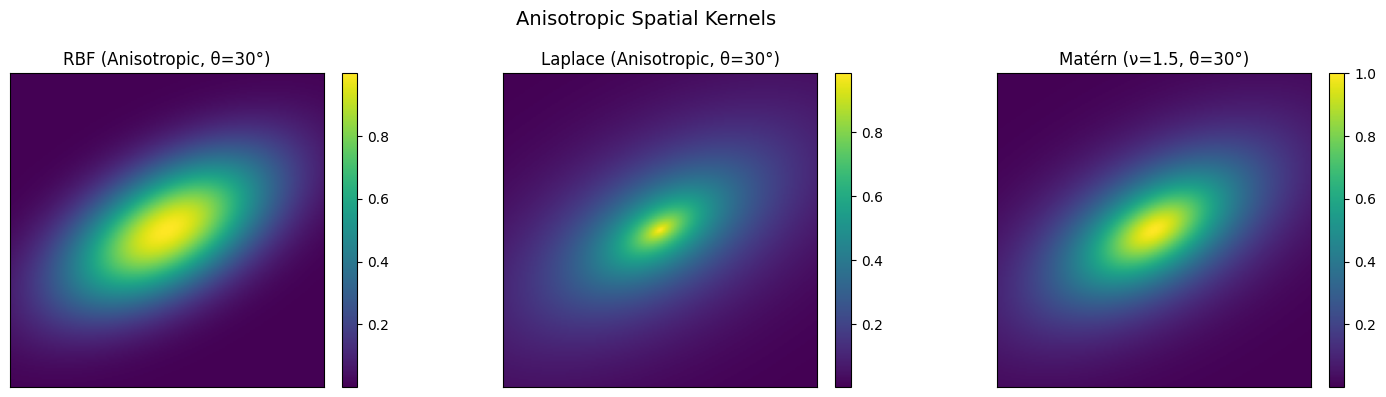

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, gamma

# --- Grid definition ---
n = 200
x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
X, Y = np.meshgrid(x, y)

# --- Transformation parameters ---
# Bandwidths in x and y directions
bx, by = 0.5, 0.25
# Orientation angle (in degrees)
theta_deg = 30
theta = np.deg2rad(theta_deg)

# --- Rotate coordinates for anisotropy ---
Xr = X * np.cos(theta) + Y * np.sin(theta)
Yr = -X * np.sin(theta) + Y * np.cos(theta)

# --- Elliptical distance metric ---
D = np.sqrt((Xr / bx)**2 + (Yr / by)**2)

# --- Kernel definitions (anisotropic forms use D) ---
def rbf_aniso(D):
    return np.exp(-0.5 * D**2)

def laplace_aniso(D):
    return np.exp(-D)

def matern_aniso(D, nu=1.5):
    D_scaled = np.sqrt(2*nu) * D
    D_scaled = np.where(D_scaled == 0, 1e-10, D_scaled)
    term = (2**(1 - nu)) / gamma(nu)
    K = term * (D_scaled**nu) * kv(nu, D_scaled)
    return K / np.max(K)

# --- Compute kernels ---
kernels = {
    f"RBF (Anisotropic, θ={theta_deg}°)": rbf_aniso(D),
    f"Laplace (Anisotropic, θ={theta_deg}°)": laplace_aniso(D),
    f"Matérn (ν=1.5, θ={theta_deg}°)": matern_aniso(D)
}

# --- Plot heatmaps ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, W) in zip(axes, kernels.items()):
    im = ax.imshow(W, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
    ax.set_title(name)
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("Anisotropic Spatial Kernels", fontsize=14)
plt.tight_layout()
plt.show()

**Aadaptive anisotropy** is where each grid point gets its own local bandwidth (bₓ, bᵧ) drawn from a data-dependent surface (e.g., density or gradient)

In real-life, that is how true adaptive GWR kernels are  leveraged and visualized.

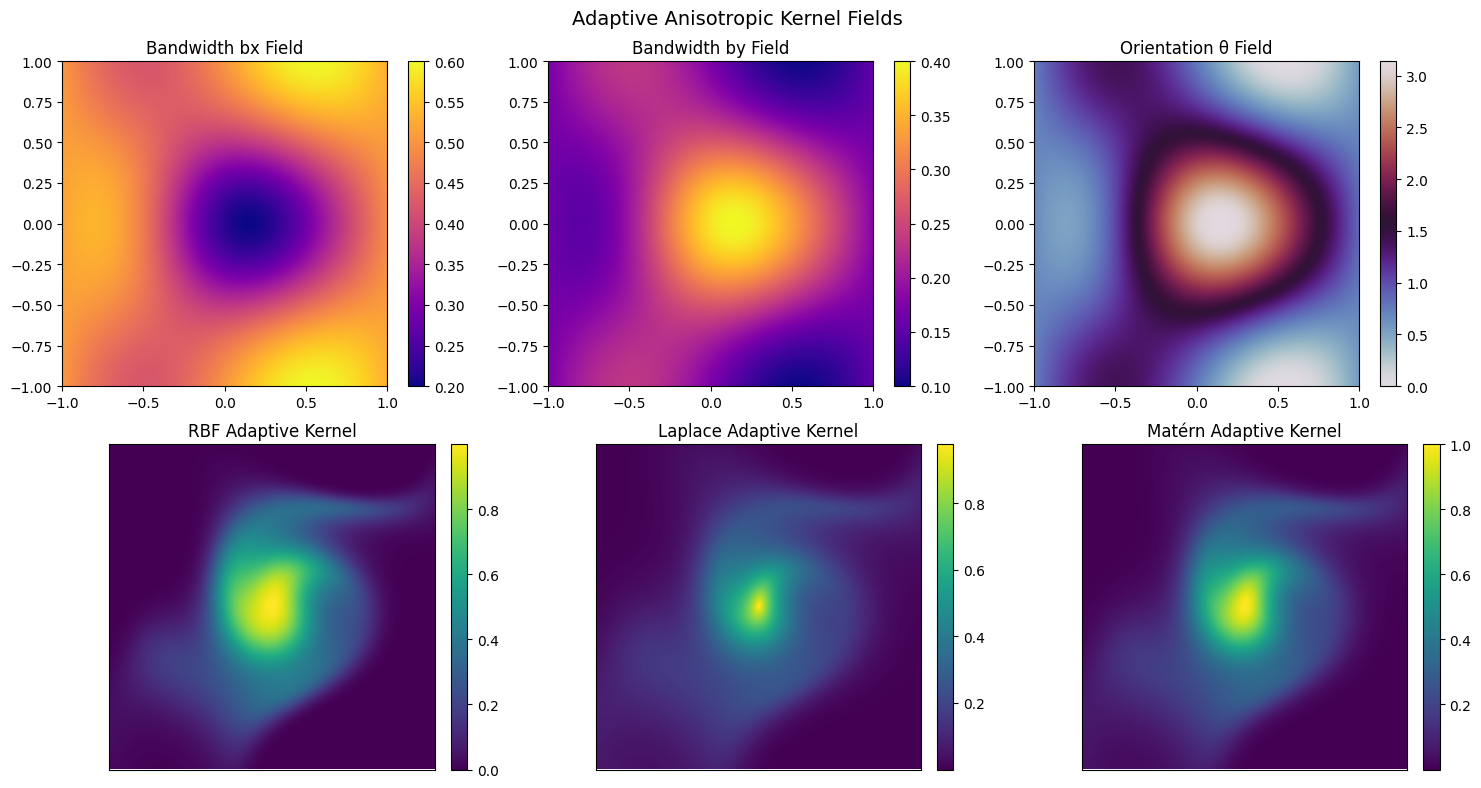

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, gamma

# --- Base grid ---
n = 200
x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
X, Y = np.meshgrid(x, y)

# --- Generate a synthetic "density field" to modulate bandwidth ---
# High density = smaller bandwidth (tighter kernel)
density = np.exp(-3 * (X**2 + Y**2)) + 0.3 * np.sin(3 * X) * np.cos(3 * Y)
density = (density - density.min()) / (density.max() - density.min())

# Map density → bandwidth range
bx_field = 0.2 + 0.4 * (1 - density)  # vary between 0.2 and 0.6
by_field = 0.1 + 0.3 * density        # vary between 0.1 and 0.4
theta_field = np.pi * density          # orientation field 0 → 180°

# --- Define function to compute anisotropic distance ---
def anisotropic_distance(X, Y, bx, by, theta):
    Xr = X * np.cos(theta) + Y * np.sin(theta)
    Yr = -X * np.sin(theta) + Y * np.cos(theta)
    return np.sqrt((Xr / bx)**2 + (Yr / by)**2)

# --- Kernel functions (parameterized by local anisotropy) ---
def rbf_adaptive(X, Y, bx_field, by_field, theta_field):
    D = anisotropic_distance(X, Y, bx_field, by_field, theta_field)
    return np.exp(-0.5 * D**2)

def laplace_adaptive(X, Y, bx_field, by_field, theta_field):
    D = anisotropic_distance(X, Y, bx_field, by_field, theta_field)
    return np.exp(-D)

def matern_adaptive(X, Y, bx_field, by_field, theta_field, nu=1.5):
    D = anisotropic_distance(X, Y, bx_field, by_field, theta_field)
    D_scaled = np.sqrt(2 * nu) * D
    D_scaled = np.where(D_scaled == 0, 1e-10, D_scaled)
    term = (2 ** (1 - nu)) / gamma(nu)
    K = term * (D_scaled ** nu) * kv(nu, D_scaled)
    return K / np.nanmax(K)

# --- Compute adaptive kernels ---
rbf_map = rbf_adaptive(X, Y, bx_field, by_field, theta_field)
laplace_map = laplace_adaptive(X, Y, bx_field, by_field, theta_field)
matern_map = matern_adaptive(X, Y, bx_field, by_field, theta_field)

# --- Plot results ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Bandwidth fields
im0 = axes[0, 0].imshow(bx_field, origin='lower', cmap='plasma', extent=[-1, 1, -1, 1])
axes[0, 0].set_title("Bandwidth bx Field")
fig.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(by_field, origin='lower', cmap='plasma', extent=[-1, 1, -1, 1])
axes[0, 1].set_title("Bandwidth by Field")
fig.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].imshow(theta_field, origin='lower', cmap='twilight', extent=[-1, 1, -1, 1])
axes[0, 2].set_title("Orientation θ Field")
fig.colorbar(im2, ax=axes[0, 2])

# Kernel maps
for ax, (name, W) in zip(axes[1], {
    "RBF Adaptive Kernel": rbf_map,
    "Laplace Adaptive Kernel": laplace_map,
    "Matérn Adaptive Kernel": matern_map
}.items()):
    im = ax.imshow(W, origin='lower', cmap='viridis', extent=[-1, 1, -1, 1])
    ax.set_title(name)
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("Adaptive Anisotropic Kernel Fields", fontsize=14)
plt.tight_layout()
plt.show()


##  How Does It Work?

The adaptive anisotropic kernel framework is used to model **spatially varying influence** by assigning each grid point its own local parameters for scale and orientation.

| Symbol | Meaning | Description |
|:--------|:---------|:-------------|
| $d(x, y)$ | Distance | Euclidean distance from the kernel center |
| $b_x, b_y$ | Local bandwidths | Control kernel spread along each axis |
| $\theta$ | Local rotation | Controls kernel orientation |
| $D(x, y)$ | Scaled distance | Elliptical distance used for anisotropy |
| $w(x, y)$ | Weight | Kernel value at a given location |

---

###  1. Elliptical Distance

For a given point $(x, y)$ and local parameters $b_x, b_y, \theta$:

$$
D(x, y) =
\sqrt{
\left(
  \frac{x \cos \theta + y \sin \theta}{b_x}
\right)^2
+
\left(
  \frac{-x \sin \theta + y \cos \theta}{b_y}
\right)^2
}
$$

This produces an **elliptical distance field**, where scale and rotation vary spatially.

---

### 2. Kernel Weight Functions

Each kernel defines how distance transforms into weight $w(x, y)$:

- **RBF (Gaussian)**  
  $$
  w(x, y) = \exp\!\left(-\tfrac{1}{2} D(x, y)^2 \right)
  $$

- **Laplace (Exponential)**  
  $$
  w(x, y) = \exp\!\big(-D(x, y)\big)
  $$

- **Matérn (ν = 1.5)**  
  $$
  w(x, y) =
  \frac{1}{2^{\nu - 1}\Gamma(\nu)}
  \big(\sqrt{2\nu}\,D(x, y)\big)^{\nu}
  K_{\nu}\!\big(\sqrt{2\nu}\,D(x, y)\big)
  $$

where $K_{\nu}$ is the modified Bessel function of the second kind, and  
$\Gamma(\nu)$ is the Gamma function.

---

###  3. Adaptivity via Density Field

A **synthetic density field** modulates each kernel’s local parameters:

$$
b_x(x, y) = 0.2 + 0.4 \,[\,1 - \rho(x, y)\,]
$$

$$
b_y(x, y) = 0.1 + 0.3 \,\rho(x, y)
$$

$$
\theta(x, y) = \pi \,\rho(x, y)
$$

where $\rho(x, y)$ represents the normalized spatial data density.

Dense regions (large $\rho$) yield smaller, rounder kernels — sparse regions yield elongated, wider kernels.

---

## Interpretation

- Areas with **dense data** → **small, circular kernels** → more localized weighting.  
- Areas with **sparse data** → **wide, elongated kernels** → smoother influence surface.  
- Orientation $\theta(x, y)$ introduces **directional dependence** (anisotropy).

This mirrors how **Adaptive GWR** adjusts local bandwidths
to account for spatial heterogeneity and non-stationarity in the data.

---


Next- we will look at how to leverge custom weight matrices for specific grids...

# Custom Weight Matrix (W) for GWR-style Local Regression & Visualization
This notebook shows how to:
1) Load or construct a custom weight matrix `W` (N×N)  
2) Validate / normalize / sparsify `W`  
3) Visualize `W` as a heatmap  
4) Run local weighted OLS (GWR-style) with `W[i, :]` as weights at focal i  
5) Grid + plot coefficient surfaces


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, LinAlgError
from scipy.interpolate import griddata

In [8]:
## Simulated Data- Can be replaced with your own
# N scattered points
np.random.seed(7)
N = 120
x = np.random.uniform(0, 100, N)
y = np.random.uniform(0, 100, N)

# Design matrix (intercept + two predictors)
X = np.column_stack([np.ones(N), x, y])

# True coefficients vary with space (just for demo)
beta_true = np.column_stack([
    5 + 0.01*(x-50),      # intercept varies weakly with x
    0.4 + 0.002*(y-50),   # coef for x depends on y
    0.2 - 0.002*(x-50)    # coef for y depends on x
])

# Generate response with local linear model + noise
y_vec = (beta_true[:,0]
         + beta_true[:,1]*x
         + beta_true[:,2]*y
         + np.random.normal(0, 5, N))

## 2) Bring your custom weight matrix `W` (N×N)
- Each **row i** will contain weights `w_ij` applied to points j when fitting at focal i.
- Rows may be unnormalized;so they should be standardized.

  - Option A: Load from CSV (N×N).
  - Option B: Build programmatically (examples below).


In [9]:
# --- Option A: Load from CSV ---
# W = np.loadtxt('/path/to/your_W.csv', delimiter=',')

# --- Option B: Build a custom matrix (example patterns) ---

def gaussian_W(x, y, bw=20.0):
    """Isotropic Gaussian weights centered at each point (full pairwise)."""
    XY = np.column_stack([x, y])
    d2 = np.sum((XY[:,None,:] - XY[None,:,:])**2, axis=2)  # N×N squared distances
    return np.exp(-0.5 * d2 / (bw**2))

def knn_mask(W, k=15):
    """Keep k largest weights per row (including self); zero out the rest."""
    W2 = np.zeros_like(W)
    idx = np.argpartition(W, -k, axis=1)[:, -k:]  # indices of k largest per row
    rows = np.arange(W.shape[0])[:,None]
    W2[rows, idx] = W[rows, idx]
    return W2

# Example: start with Gaussian, then kNN sparsify
W = gaussian_W(x, y, bw=18.0)
W = knn_mask(W, k=20)  # optional sparsification

## 3) Weight matrix utilities
- Validate shape & diagonals
- Row-standardize to sum to 1 (optional, but recommended for algebraic convergence)
- Symmetrize (optional, recommended if you need an undirected notion)

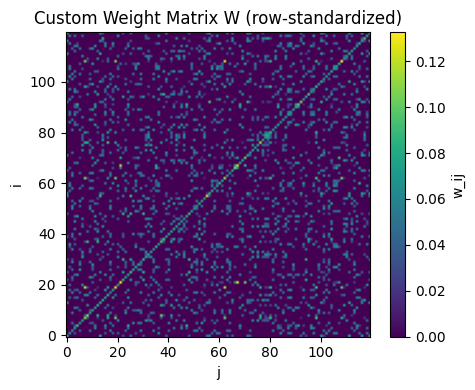

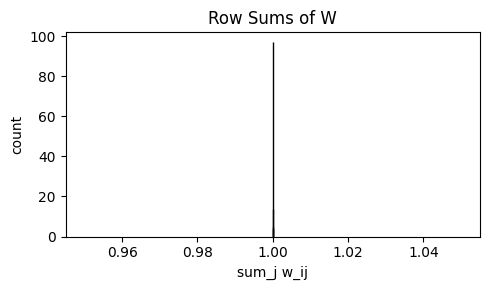

In [10]:
def validate_W(W, N):
    assert W.shape == (N, N), f"W must be {N}x{N}"
    if not np.all(np.isfinite(W)):
        raise ValueError("W has non-finite values")
    # ensure non-negative
    if np.any(W < 0):
        print("Warning: W has negative entries; check your construction.")

def row_standardize(W, eps=1e-12):
    s = W.sum(axis=1, keepdims=True)
    s = np.where(s < eps, 1.0, s)  # avoid divide-by-zero
    return W / s

def symmetrize_max(W):
    return np.maximum(W, W.T)

validate_W(W, N)
W = row_standardize(W)        # common choice
# W = symmetrize_max(W)       # optional, if desired

# Visualize W
plt.figure(figsize=(5,4))
plt.imshow(W, origin='lower', cmap='viridis')
plt.title("Custom Weight Matrix W (row-standardized)")
plt.xlabel("j"); plt.ylabel("i")
plt.colorbar(label="w_ij")
plt.tight_layout(); plt.show()

# Quick degree / row-sum check (should be ~1 after standardization)
plt.figure(figsize=(5,3))
plt.hist(W.sum(axis=1), bins=20, edgecolor='k')
plt.title("Row Sums of W")
plt.xlabel("sum_j w_ij"); plt.ylabel("count")
plt.tight_layout(); plt.show()

## 5) Local weighted OLS (instead of GWR)
For each focal location i, fit:
$$
\hat\beta_i = \arg\min_\beta \sum_{j=1}^{N} w_{ij} (y_j - X_j \beta)^2
\quad\Rightarrow\quad
\hat\beta_i = (X^\top W_i X + \lambda I)^{-1} X^\top W_i y,
$$
where $W_i=\mathrm{diag}(w_{i1},\dots,w_{iN})$ and small $\lambda$ stabilizes inverses.


In [11]:
def local_betas(X, y_vec, W, lam=1e-6):
    """
    Returns B (N x P): each row i is beta_hat for focal i using weights W[i,:].
    """
    N, P = X.shape
    B = np.zeros((N, P))
    XT = X.T
    I = np.eye(P)
    for i in range(N):
        w = W[i, :]
        # Weighted normal equations
        # XtWX = X^T diag(w) X  ;  XtWy = X^T diag(w) y
        XtWX = XT @ (w[:, None] * X)
        XtWy = XT @ (w * y_vec)
        try:
            B[i, :] = inv(XtWX + lam * I) @ XtWy
        except LinAlgError:
            # fallback: pseudo-inverse
            B[i, :] = np.linalg.pinv(XtWX + lam * I) @ XtWy
    return B

B_hat = local_betas(X, y_vec, W, lam=1e-4)  # N×P

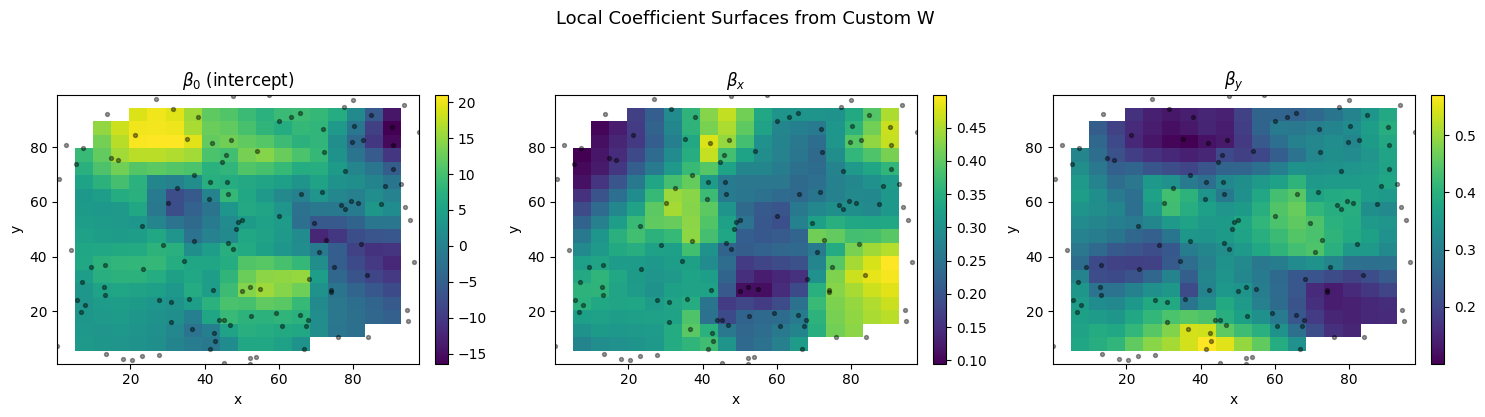

In [12]:
## Interpolate Coefficient Surfaces to a  20x20 Grid for visualization of the outcome
gx, gy = np.mgrid[x.min():x.max():20j, y.min():y.max():20j]

titles = [r"$\beta_0$ (intercept)", r"$\beta_x$", r"$\beta_y$"]
fig, axes = plt.subplots(1, 3, figsize=(15,4))

for k, ax in enumerate(axes):
    surf = griddata(points=np.column_stack([x, y]),
                    values=B_hat[:, k],
                    xi=(gx, gy),
                    method='linear')
    im = ax.imshow(surf.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],
                   cmap='viridis', aspect='auto')
    ax.scatter(x, y, s=8, c='k', alpha=0.4)  # data locations
    ax.set_title(titles[k]); ax.set_xlabel("x"); ax.set_ylabel("y")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle("Local Coefficient Surfaces from Custom W", y=1.03, fontsize=13)
plt.tight_layout()
plt.show()